# Objectives

1. Animated Subtree

1. Sampling Bias
    - A. Full
    - B. Russia "Knockout"
    - C. Germany "Knockout"
1. Geocoding Bias
1. Drawing Bias

---
# Setup

## Modules

In [1]:
import os
import dill
import copy
import math

from Bio import Phylo
import pandas as pd
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib import lines, patheffects, animation, gridspec

## Variables

In [2]:
from config import *

# Custom script variables
SCRIPT_NAME = "geo"
PREV_DIR_NAME = "mugration"
PREV_SCRIPT_NAME = "mugration_model"

try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chromosome", "5"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
    
READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
MISSING_DATA = WILDCARDS[2]

BASEMAP = cimgt.Stamen('terrain-background')
NAME_COL = "Name"

In [3]:
import sys, importlib
importlib.reload(sys.modules['config'])
from config import *

## File Paths

In [4]:
config_dir = os.path.join(project_dir, "config")
results_dir = os.path.join(project_dir, "results")

outdir       = os.path.join(results_dir, SCRIPT_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),)
#tree_dill    = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),PREV_SCRIPT_NAME + "_timetree.treetime.obj")
#tree_df_dill = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".df.obj")
tree_path    = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + "_timetree.nwk")
tree_df_path = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".tsv")
aln_path     = os.path.join(results_dir,"snippy_multi",READS_ORIGIN,"snippy-core_{}.snps.filter{}.aln".format(LOCUS_NAME, MISSING_DATA))

# Auspice
auspice_latlon_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_latlon.tsv")
auspice_colors_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_colors.tsv")
auspice_config_path = os.path.join(config_dir, "auspice_config.json")
auspice_remote_dir_path = os.path.join(project_dir, "auspice/")

#print("tree_dill:\t", tree_dill)
#print("tree_df_dill:\t", tree_df_dill)
print("aln path:\t", aln_path)
print("auspice_latlon_path:", auspice_latlon_path)
print("auspice_colors_path:", auspice_colors_path)
print("auspice_config_path:", auspice_config_path)
print("auspice_remote_dir_path:", auspice_remote_dir_path)
print("outdir:", outdir)

# Create output directory if it doesn't exist
while not os.path.exists(outdir):
    os.makedirs(outdir)   
    
SCRIPT_NAME = "geo_animate"

aln path:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/snippy_multi/all/snippy-core_chromosome.snps.filter5.aln
auspice_latlon_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_latlon.tsv
auspice_colors_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_colors.tsv
auspice_config_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/config/auspice_config.json
auspice_remote_dir_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/auspice/
outdir: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/geo/all/chromosome_filter5


## Import Tree

In [5]:
# with open(tree_dill, "rb") as infile:
#     tt = dill.load(infile)
# tt.tree.ladderize(reverse=False)

tree = Phylo.read(tree_path, "newick")
tree.ladderize(reverse=False)

## Import Dataframe

In [6]:
# with open(tree_df_dill, "rb") as infile:
#     tree_df = dill.load(infile)
# display(tree_df)

tree_df = pd.read_csv(tree_df_path, sep='\t')
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index(NAME_COL, inplace=True)

# Import Colors

In [7]:
colors_df = pd.read_csv(auspice_colors_path, sep='\t', header=None)
colors_df.columns = ["Attribute", "State", "Color"]
colors_df.fillna(NO_DATA_CHAR, inplace=True)

# Add sizes
colors_df["Size"] = [NO_DATA_CHAR for i in range(0,len(colors_df))]
i = 0
for attr in list(dict.fromkeys(colors_df["Attribute"])):
    title_attr = attr.replace("_"," ").title().replace(" ","_")
    attr_df =  colors_df[colors_df["Attribute"] == attr]
    for state in attr_df["State"]:
        if attr == "branch_number":
            state = int(state)
        matches = tree_df[tree_df[title_attr] == state]
        colors_df.at[i,"Size"] = len(matches)
        i += 1

display(colors_df)
    
# Convert to dict
colors_dict = {}
sizes_dict = {}
for rec in colors_df.iterrows():
    attr = rec[1]["Attribute"]
    state = rec[1]["State"]
    color = rec[1]["Color"]
    size = rec[1]["Size"]

    if attr not in colors_dict:
        colors_dict[attr] = {}
    if attr not in sizes_dict:
        sizes_dict[attr] = {}        
    colors_dict[attr][state] = color        
    sizes_dict[attr][state] = size

,Attribute,State,Color,Size
0,branch_number,0,#8000ff,210
1,branch_number,3,#00b4ec,12
2,branch_number,4,#80ffb4,15
3,branch_number,2,#ffb462,173
4,branch_number,1,#ff0000,206
...,...,...,...,...
202,province,Midlands,#ff1c0e,1
203,province,State of Mato Grosso,#ff150b,1
204,province,MSila,#ff0e07,1
205,province,La Paz,#ff0704,1


---
# 1. Animate Subtree

In [8]:
branch   = "1.PRE"
geo_attr = "Province"

## Create Subtree and Dataframe

In [9]:
clade_df = tree_df[tree_df["Mugration_Branch_Major"] == branch]
clade = tree.common_ancestor(clade_df.index)
parent_node = copy.deepcopy(get_parent(tree, clade.root.name))
parent_rec = tree_df[tree_df.index.str.contains(parent_node.name)]
clade = parent_node
clade_df = clade_df.append(parent_rec)

# Prune clades outside
prune_nodes = []

for c in clade.find_clades(order="postorder"):
    if c.name not in clade_df.index:
        prune_nodes.append(c)
        
for node in prune_nodes:
    if node in clade.find_clades(node):
        try:
            clade.prune(node)
        except AttributeError as e:
            print(e)
            continue

# Clean up dataframe
for node in clade_df.index:
    if node not in [c.name for c in clade.find_clades()]:
        clade_df.drop(node, inplace=True)


display(clade_df)

can't set attribute


,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad,Mugration_Branch_Number,Mugration_Branch_Number_Confidence,Mugration_Branch_Number_Entropy,Mugration_Branch_Major,Mugration_Branch_Major_Confidence,Mugration_Branch_Major_Entropy,Mugration_Branch_Minor,Mugration_Branch_Minor_Confidence,Mugration_Branch_Minor_Entropy,Mugration_Country,Mugration_Country_Confidence,Mugration_Country_Entropy,Mugration_Country_Lat,Mugration_Country_Lon,Mugration_Province,Mugration_Province_Confidence,Mugration_Province_Entropy,Mugration_Province_Lat,Mugration_Province_Lon
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE427,100,88.1,2.346e-07,black,0.001052,421.403633,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.298620e-08,1.397220,2.148914e-07,1315-09-22,1315.723295,"[1277.0572750664792, 1318.4601112730293]","[743.9427249335208, 702.5398887269707]",9.142302,5283.991552,421.403633,1315.723295,0.000052,False,1,0.999248,7.076729e-03,1.PRE,0.999292,6.846903e-03,1.PRE0,0.398808,1.543887e+00,Russia,0.655249,9.209812e-01,64.686314,97.745306,Tatarstan,0.350106,1.632695e+00,55.448217,50.476359
SAMEA5818806,NA,NA,2.35e-08,grey,0.001052,411.000000,LAI009,[1300:1400],[-721:-621],Russia,Tatarstan,64.6863,97.7453,55.4482,50.4764,Second Pandemic,1.PRE,1.PRE0,SAMEA5818806,KEEP: SRA Ancient,1,1.276070e-09,0.137296,2.680808e-22,1315-09-22,1315.723295,"[1300.0, 1318.2610714923705]","[721.0, 702.7389285076295]",0.000000,5283.991552,411.000000,1350.000000,0.000052,False,1,1.000000,-1.000089e-12,1.PRE,1.000000,-1.000089e-12,1.PRE0,1.000000,-1.000089e-12,Russia,1.000000,-1.000089e-12,64.686314,97.745306,Tatarstan,1.000000,-1.000089e-12,55.448217,50.476359
NODE428,100,97.7,2.346e-07,red,0.001052,431.807266,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.586495e-08,1.706954,2.148911e-07,1322-10-09,1322.771898,"[1288.8041088190141, 1326.8728832201582]","[732.1958911809859, 694.1271167798418]",7.048603,5291.040155,431.807266,1322.771898,0.000052,False,1,1.000000,2.329058e-11,1.PRE,1.000000,2.277747e-11,1.PRE1,0.999998,3.479665e-05,Germany,0.796769,7.008068e-01,51.083420,10.423447,Bavaria,0.915565,4.506905e-01,48.946756,11.403872
NODE429,99,95.4,4.692e-07,red,0.001053,418.448730,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.854963e-08,1.995805,4.297898e-07,1338-02-21,1338.142431,"[1327.5938374426103, 1375.4658081585108]","[693.4061625573897, 645.5341918414892]",15.370533,5306.410689,418.448730,1338.142431,0.000053,False,1,1.000000,8.567376e-08,1.PRE,1.000000,2.209338e-07,1.PRE1,1.000000,9.558136e-07,Germany,0.882693,5.209671e-01,51.083420,10.423447,Bavaria,0.943209,3.223245e-01,48.946756,11.403872
SAMEA7293136,NA,NA,2.346e-07,grey,0.001053,417.000000,COL001,[1300:1400],[-721:-621],Italy,Lazio,42.6384,12.6743,41.9808,12.7662,Second Pandemic,1.PRE,1.PRE1,SAMEA7293136,KEEP: SRA Ancient,1,7.840284e-09,0.843558,2.149584e-07,1363-01-06,1363.014276,"[1350.6889249938997, 1400.0]","[670.3110750061003, 621.0]",24.871845,5331.282534,417.000000,1350.000000,0.000053,False,1,1.000000,-1.000089e-12,1.PRE,1.000000,-1.000089e-12,1.PRE1,1.000000,-1.000089e-12,Italy,1.000000,-9.998669e-13,42.638426,12.674297,Lazio,1.000000,-1.000089e-12,41.980804,12.766231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA5054090,NA,NA,2.624e-07,grey,0.001053,450.000000,Ber45,[1300:1400],[-721:-621],The Netherlands,North Brabant,52.5002,5.74808,51.6018,5.44414,Second Pandemic,1.PRE,1.PRE2,SAMEA5054090,KEEP: SRA A

## Convert Dataframe to Geopandas

In [10]:
# Convert dataframe to geopandas
geometry = []
for rec in clade_df.iterrows():
    sample = rec[0]
    x = clade_df["Mugration_" + geo_attr + "_Lon"][sample] 
    y = clade_df["Mugration_" + geo_attr + "_Lat"][sample]
    geometry.append(shapely.geometry.Point(x,y))

clade_gdf = geopandas.GeoDataFrame(clade_df, crs=CRS, geometry=geometry)   

## Add Nodes

In [25]:
# ---------------------------------------
# Root Data
root_geom = clade_gdf["geometry"][clade.root.name]
root_date = clade_gdf["timetree_num_date"][clade.root.name]
root_state = clade_df["Mugration_Branch_Major"][clade.root.name]
root_color = colors_dict["branch_major"][root_state] 
root_marker = lines.Line2D([root_geom.x], 
            [root_geom.y],
            marker="*",
            markerfacecolor=root_color, 
            markeredgecolor="black", 
            markeredgewidth=0.5,
            markersize=10, 
            zorder=4,
        )
# ---------------------------------------
# Node and Connections Data
network = tree2network(clade)
network_connections = []
node_markers = []

for connection in network:
    # Node names
    origin_name = connection[0].name
    dest_name = connection[1].name
    
    # Node Geometry
    origin_geom = clade_gdf["geometry"][origin_name]
    dest_geom = clade_gdf["geometry"][dest_name]
    
    # Aesthetic
    dest_state = clade_gdf["Mugration_Branch_Major"][dest_name]
    dest_color = colors_dict["branch_major"][dest_state] 
    dest_confidence = clade_gdf["Mugration_" + geo_attr + "_Confidence"][dest_name]
    dest_geo   = clade_df["Mugration_" + geo_attr][dest_name]
    dest_size  = sizes_dict[geo_attr.lower()][dest_geo]     
            
    if dest_confidence < MUG_CONF_THRESH:
        dest_color = "white"
    
    # Create the connection line
    if origin_geom != dest_geom:        
        connection = lines.Line2D(
           [origin_geom.x, dest_geom.x], 
           [origin_geom.y, dest_geom.y],  
           color=dest_color,
           lw=1.5,
           #transform=ccrs.Geodetic(),
           path_effects=[
               patheffects.Stroke(linewidth=2, foreground='black'),
               patheffects.Normal(),
           ],
           zorder=2,
           label="{},{}".format(origin_name, dest_name),
        )        
        network_connections.append(connection) 
        #network_connect_uniq.append([origin_geom, dest_geom])

## Animate

In [12]:
min_date = math.floor(min(clade_df["timetree_num_date"]))
min_date = int(math.floor(min_date / 100.0)) * 100

max_date = math.ceil(max(clade_df["timetree_num_date"]))
max_date = int(math.ceil(max_date / 100.0)) * 100
tick_step = 100
frame_step = 5
time_xticks = range(min_date, max_date + 1, tick_step)
animate_frames = range(min_date, max_date + 1, frame_step)
# Keys are frames

animate_dict = {}
for i in range(0,len(animate_frames)):
    animate_dict[i] = animate_frames[i]

total_frames = len(animate_dict)
fps = int(100 / frame_step) # frames per second
speed = 1
spf = 1000 / (fps * speed) # (milli)seconds per frame

print(min_date, max_date, tick_step)
#print(animate_dict)

1200 1800 100


<IPython.core.display.Javascript object>


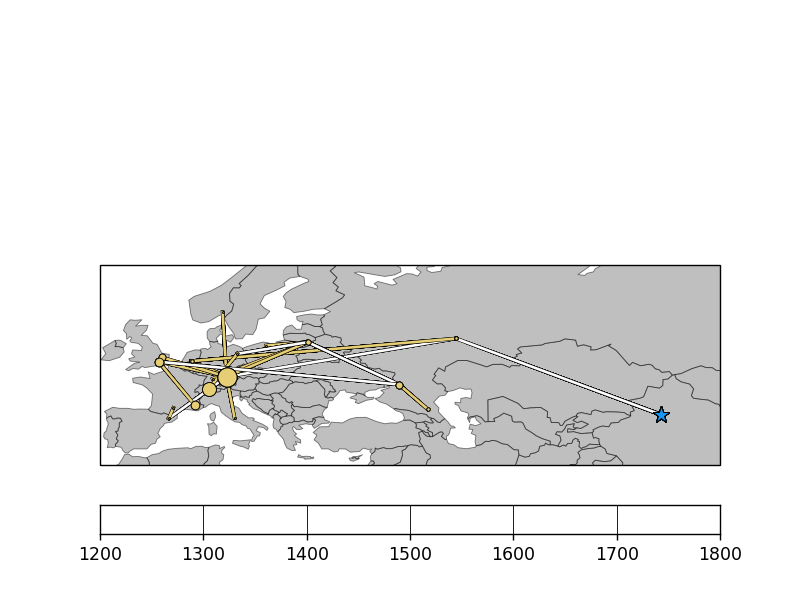

Animation will be 121 frames.


/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


In [31]:
%matplotlib notebook

fig_maptime = plt.figure()
gs          = gridspec.GridSpec(2, 1, figure=fig_maptime, 
                                wspace=0, 
                                hspace=-0.5, 
                                height_ratios=[20, 1])
ax_map      = fig_maptime.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax_time     = fig_maptime.add_subplot(gs[1, 0])

# Customize Map Axis
#ax_map.add_image(BASEMAP, 4)
world_polygons.plot(ax=ax_map, color="grey", alpha=0.5, ec="black", lw=0.5)
mb = Polygon(clade_gdf['geometry']).bounds
xb, yb = 10, 8
map_bounds = [mb[0] - xb, mb[2] + xb, mb[1] - yb, mb[3] + yb]
ax_map.set_extent(map_bounds, crs=ccrs.PlateCarree()) 

# Customize Time Axis
ax_time.set_xticks(time_xticks)
ax_time.set_xlim(min_date, max_date)
ax_time.set_ylim(0,0.1)
ax_time.set_yticks([])
[ax_time.axvline(x, color="black", alpha=1) for x in time_xticks]

time_line = ax_time.axvline(x=0, color='grey', lw=5, alpha=0.75)

def animate_init():
    time_line.set_data([],[])
    return time_line,

def animate_update(frame, progressive=False):
    frame_date = animate_dict[frame]

    # Timeline animation
    time_line.set_data([frame_date,frame_date], [0,1])
            
    # Check for connections
    for connection in network_connections: 
        origin_name = connection.get_label().split(",")[0]
        origin_date = clade_df["timetree_num_date"][origin_name]
        dest_name = connection.get_label().split(",")[1]
        dest_date = clade_df["timetree_num_date"][dest_name]
        dest_geom = clade_gdf["geometry"][dest_name]
        dest_geo   = clade_df["Mugration_" + geo_attr][dest_name]
        dest_size  = sizes_dict[geo_attr.lower()][dest_geo] 
        
        # Plot the root
        if frame == 0:
            ax_map.add_line(copy.copy(root_marker))
        # This marker will be plotted in future animation
        if origin_date > frame_date: continue
       
        num_seg = math.ceil((dest_date - origin_date) / frame_step) 
        date_seg_delta = (dest_date - origin_date)/ num_seg
        
        marker = lines.Line2D([dest_geom.x], 
                [dest_geom.y],
                marker="o",
                markerfacecolor=dest_color, 
                markeredgecolor="black", 
                markeredgewidth=0.5,
                markersize=dest_size, 
                zorder=3,
                label=dest_name,                              
            )
                
        # Option 1) Non-Progressive Lines
        if not progressive or num_seg <= 1:
            if dest_date <= frame_date:
                # Check if it was previously plotted
                if dest_date > animate_dict[frame - 1]:
                    ax_map.add_line(copy.copy(connection)) 
                    
        # Option 2) Progressive Lines
        else:
            conn_seg = segment_line(connection, num_seg, cumulative=True)
            for i in range(1,len(conn_seg) + 1):
                seg_date = origin_date + (date_seg_delta * i)
                if seg_date <= frame_date:
                    # Check if it was previously plotted
                    if seg_date > animate_dict[frame - 1]: 
                        ax_map.add_line(copy.copy(conn_seg[i - 1]))
                        
        # Add Markers
        if dest_date > frame_date: continue
        # Check if it was previously plotted
        if dest_date <= animate_dict[frame - 1]: continue
        ax_map.add_line(copy.copy(marker))                
                                                 
    return time_line,

#animate_init()
#for i in range(0,1):
#     animate_update(i, progressive=True)

print("Animation will be {} frames.".format(len(animate_dict)))
ani = animation.FuncAnimation(
    fig=fig_maptime, 
    func=animate_update,
    fargs=(True,),
    init_func=animate_init,
    interval=spf,
    frames=len(animate_dict), 
    #frames=40,
    blit=True,
    repeat=True
    )

out_path = os.path.join(outdir, "geo_animate_{}.gif".format(branch))
ani.save(out_path, writer="imagemagick")
#plt.show()

In [ ]:
import sys, importlib
importlib.reload(sys.modules['config'])
from config import *

---
# Export

## Dataframe

In [ ]:
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)

## Timetrees

In [ ]:
# Phyloxml
tt_copy = copy.deepcopy(tt)
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + "_timetree.xml" )
Phylo.write(tt_copy.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_timetree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_timetree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_timetree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

## Divtrees

In [ ]:
tt_copy = copy.deepcopy(tt)
# Convert to divtree
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length

# Phyloxml
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + "_divtree.xml" )
Phylo.write(tt_copy.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_divtree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_divtree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_divtree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

## Augur JSON

In [ ]:
augur_dict = augur_export(
    tree_path=out_path_nwk, 
    aln_path=aln_path, 
    tree=tt_copy.tree, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "lat", "lon"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["NODE0"])

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

## Auspice JSON

In [ ]:
auspice_dict = auspice_export(
    tree=tt_copy.tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlon_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")